In [28]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *

from torch.utils.data import random_split
from torch.utils.data import DataLoader
# from torchmin import minimize
import gpytorch

from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *
from util.util_func import *

from eval.torch_slip_dataset import TorchWMRSlipDataset

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [29]:
# import dataset in pytorch form

slip_dataset_path = '/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl'
# train_dataset_path = '/home/dominic/repos/norlab_WMRD/data/husky/vel_mask_array_all.npy'

slip_train_dataset = TorchWMRSlipDataset(slip_dataset_path, gp_state='x')

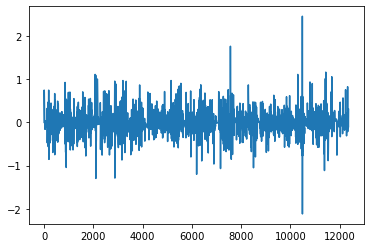

In [30]:
# plot slip dataset output values

plt.plot(slip_train_dataset.y_train)

In [31]:
# import GP model

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


state_dict = torch.load('../eval/training_results/marmotte/gp_slip/grand_salon_a/model_state.pth')
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(slip_train_dataset.x_train, slip_train_dataset.y_train, likelihood)  # Create a new GP model

model.load_state_dict(state_dict)

<All keys matched successfully>

In [33]:
# compute and plot GP predictions on dataset

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

print(slip_train_dataset.x_train)

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(slip_train_dataset.x_train.float()))
lower, upper = observed_pred.confidence_region()

plt.plot(slip_train_dataset.y_train)
plt.plot(observed_pred.mean.detach().numpy())

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.7480,  0.0413, 14.9594,  0.8270],
        [ 0.7480,  0.0413,  0.0000,  0.0000],
        ...,
        [ 0.5566, -1.3669,  0.0000,  0.0000],
        [ 0.5566, -1.3669,  0.0000,  0.0000],
        [ 0.5566, -1.3669,  0.0000,  0.0000]], dtype=torch.float64)


RuntimeError: expected scalar type Double but found Float